Idea of this notebook: 

Time series prediction of daily new Covid-Cases in Chile, with CASEN data as features

Predict what?
* For each region or for the whole country, predict future development (next five or ten days) of Covid cases/deaths
* y = number of cases
* x = casen data + more features (s. time series tips) 

data: CASEN data
Covid data: from MINSAL


1. Read in data: CASEN data, data from MINSAL about regions
2. Data exploration
3. Data visualization
3. Metrics: low RSME (good for time series) 
4. Get features with high correlation
5. build model with those features (maybe LR)
6. GridSearch with different models (LR, Kregressor, RandomForestRegressor) 
7. Findings/conclusion


# Read in data

In [1]:
# Read in libraries
import pandas as pd
pd.options.mode.chained_assignment = None  

import numpy as np

from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import seaborn as sns
sns.set_context('poster')

from lightgbm import LGBMRegressor

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn import neighbors
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error


# Read in CASEN data about social vulnerability
casen = pd.read_stata('Casen 2017.dta', convert_categoricals = False)

# Read in data about Covid-19 cases and deaths in Chilean regions
cases_regions = pd.read_csv(
    'https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto3/CasosTotalesCumulativo_T.csv',
    parse_dates = True)

deaths_regions = pd.read_csv(
    'https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto14/FallecidosCumulativo_T.csv',
    parse_dates = True)

# Read in Google data about mobility
mobility = pd.read_csv('Global_Mobility_Report.csv')

D:\Python\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Data exploration

Three dataframes: 
* casen: CASEN data
* cases_regions: data about cases per region
* deaths_regions: data about deaths per region
* mobility: data about mobility per country and region

In [2]:
casen.head(2)

,folio,o,id_vivienda,hogar,region,provincia,comuna,zona,expr,expc,...,hh_d_estado,hh_d_servbas,hh_d_entorno,hh_d_accesi,hh_d_medio,hh_d_appart,hh_d_tsocial,hh_d_seg,pobreza_multi_4d,pobreza_multi_5d
0,1.101100e+11,1,1.101100e+09,1,1,11,1101,1,39,33,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,NaN,NaN
1,1.101100e+11,1,1.101100e+09,1,1,11,1101,1,39,33,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [3]:
cases_regions.head(2)

,Region,Arica y Parinacota,Tarapacá,Antofagasta,Atacama,Coquimbo,Valparaíso,Metropolitana,O’Higgins,Maule,Ñuble,Biobío,Araucanía,Los Ríos,Los Lagos,Aysén,Magallanes,Total
0,2020-03-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2020-03-04,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0


In [4]:
deaths_regions.head(2)

,Region,Arica y Parinacota,Tarapacá,Antofagasta,Atacama,Coquimbo,Valparaíso,Metropolitana,O’Higgins,Maule,Ñuble,Biobío,Araucanía,Los Ríos,Los Lagos,Aysén,Magallanes,Total
0,2020-03-22,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2020-03-23,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [5]:
mobility.head()

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,2020-02-15,0.0,4.0,5.0,0.0,2.0,1.0
1,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,2020-02-16,1.0,4.0,4.0,1.0,2.0,1.0
2,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,2020-02-17,-1.0,1.0,5.0,1.0,2.0,1.0
3,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,2020-02-18,-2.0,1.0,5.0,0.0,2.0,1.0
4,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,2020-02-19,-2.0,0.0,4.0,-1.0,2.0,1.0


In [6]:
def first_look(lst):
    """
    Provides useful information about a list of dataframes: Name, Shape, NaNs and describe().
    
    Input: 
        lst(List): List of DataFrames
    
    Output: 
        Prints name, shape, share of NaNs, describe()
    """
    for item in lst:
        def get_df_name(df):
            name =[x for x in globals() if globals()[x] is df][0]
            return name
        print('Information for DataFrame ' + get_df_name(item))
        print('The shape of this DataFrame is {}.'.format(item.shape))
        print('NaN share for each column:')
        print((np.sum(item.isna() == True))/item.shape[0])
        print('Describe() for each column:')
        print(item.describe())
        print('---')

In [7]:
df_list = [casen, cases_regions, deaths_regions, mobility]

first_look(df_list)

Information for DataFrame casen
The shape of this DataFrame is (216439, 804).
NaN share for each column:
folio               0.000000
o                   0.000000
id_vivienda         0.000000
hogar               0.000000
region              0.000000
                      ...   
hh_d_appart         0.005895
hh_d_tsocial        0.000961
hh_d_seg            0.000961
pobreza_multi_4d    0.039933
pobreza_multi_5d    0.045588
Length: 804, dtype: float64
Describe() for each column:
              folio              o   id_vivienda          hogar  \
count  2.164390e+05  216439.000000  2.164390e+05  216439.000000   
mean   8.704111e+11       2.425288  8.704111e+09       1.037392   
std    3.926348e+11       1.462053  3.926348e+09       0.229385   
min    1.101100e+11       1.000000  1.101100e+09       1.000000   
25%    5.804101e+11       1.000000  5.804101e+09       1.000000   
50%    8.401102e+11       2.000000  8.401102e+09       1.000000   
75%    1.310910e+12       3.000000  1.310910e+10   

country_region_code                                   0.000775
country_region                                        0.000000
sub_region_1                                          0.019740
sub_region_2                                          0.196953
metro_area                                            0.993611
iso_3166_2_code                                       0.804288
census_fips_code                                      0.740773
date                                                  0.000000
retail_and_recreation_percent_change_from_baseline    0.367199
grocery_and_pharmacy_percent_change_from_baseline     0.380944
parks_percent_change_from_baseline                    0.527815
transit_stations_percent_change_from_baseline         0.511364
workplaces_percent_change_from_baseline               0.054370
residential_percent_change_from_baseline              0.505332
dtype: float64
Describe() for each column:
       census_fips_code  retail_and_recreation_percent_change_from_baseline

# Data visualization: Cases and fatalities in Chile

In [8]:
def timeline_plot(df, title):
    """
    A function to plot a seaborn diagram which shows the development of Covid-19 data in Chile. 
    For better readability, the function returns a log scale plot. 
    
    Input: 
        df (DataFrame): DataFrame with information about Covid-19 cases/deaths in Chile
        title (string): Specify the kind of the plot (cases or deaths) 
        
    Output: 
        A seaborn plot. 
    """

    # Transform wide dataframe to long dataframe 
    df_melt = pd.melt(
        df, id_vars = 'Region', 
        value_vars = df.columns.drop('Region'),
        var_name='Regions', 
        value_name='Cases'
    )

    # Apply pandas to datetime and rename column for better understanding
    df_melt['Region'] = pd.to_datetime(df_melt['Region'], format = '%Y-%m-%d')
    df_melt = df_melt.rename(columns = {'Region': 'Date'}).sort_values('Cases', ascending = False)

    # Make a plot 
    f, ax = plt.subplots(figsize = (16, 10))
    
    g = sns.lineplot(
        df_melt.Date, 
        df_melt.Cases, 
        hue = df_melt.Regions
    )

    plt.xlabel('Date', fontsize = 20)
    plt.ylabel('{} (log scale)'.format(title), fontsize = 20)
    plt.title('Covid-19 {} in Chile (log scale)'.format(title), fontsize = 25)
    
    ax.yaxis.tick_right()
    ax.set_yscale('log')
    plt.tick_params(labelsize=20, rotation=0)
    plt.legend(scatterpoints=1, frameon=True, labelspacing=.2, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5)

    plt.grid(False)
    ax.yaxis.grid()
    sns.despine()
    plt.show()

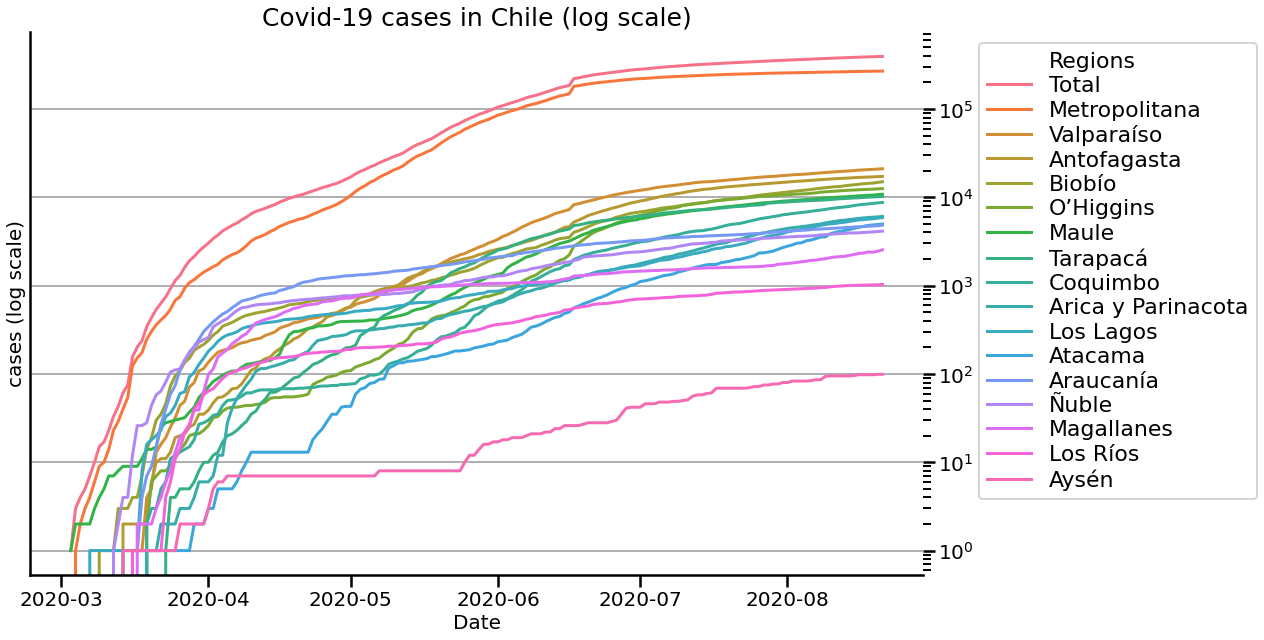

In [9]:
timeline_plot(cases_regions, 'cases')

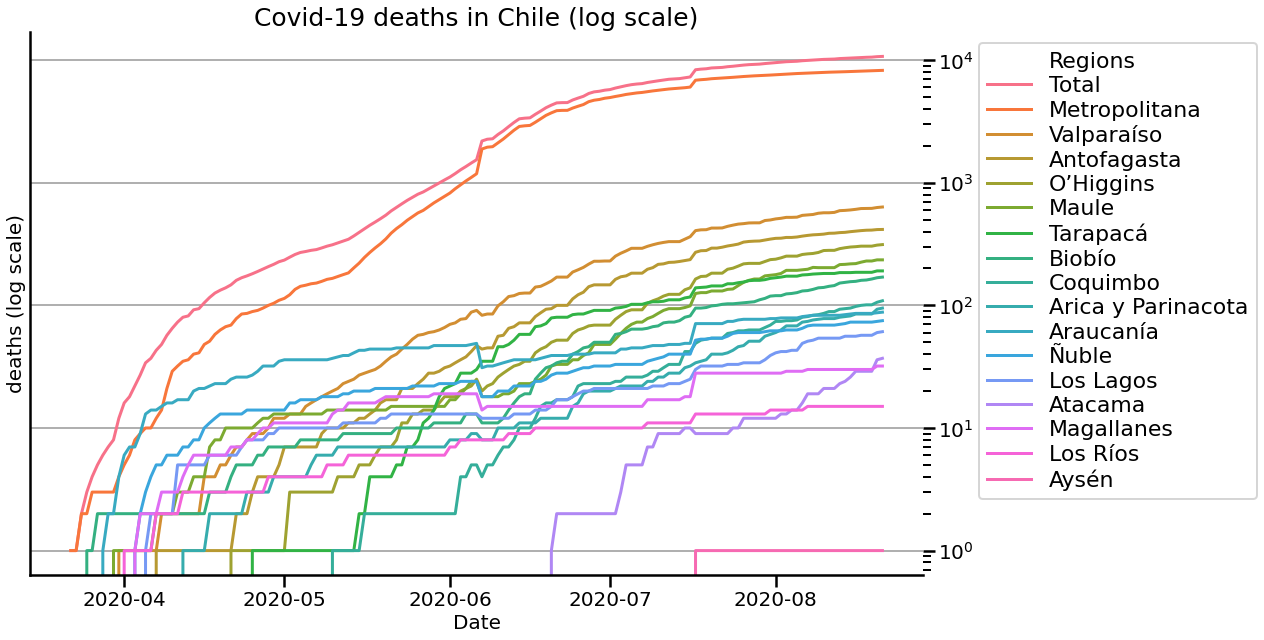

In [10]:
timeline_plot(deaths_regions, 'deaths')

# Data preparation

## Preparation of the cases/deaths DataFrames

In [11]:
# Convert the 'Region' column of the cases/deaths DataFrames to datetime: 
cases_regions.loc[:, 'Region'] = pd.to_datetime(cases_regions.loc[:, 'Region'])
deaths_regions.loc[:, 'Region'] = pd.to_datetime(deaths_regions.loc[:, 'Region'])

## Preparation and visualization of the CASEN data

In [12]:
# Before visualizing the CASEN data, we should have a look at the amount of NaNs. 
# Unfortunaetely, the CASEN data has a lot of columns with many NaNs: 
(np.sum(casen.isna() == True)/casen.shape[0]).sort_values(ascending = False).head(20)

e9com_p_cod    0.999751
e19_2          0.999580
y2004          0.999501
y20dmonto      0.999501
yama           0.999325
y0512          0.999316
y26_4h_mo      0.999307
yinv02         0.999252
y0511          0.999238
y26_4j_mo      0.999205
yah2           0.999178
y0509          0.999154
yrut           0.999154
y26_4e_mo      0.999099
ydon           0.999085
y0504          0.999039
yre2           0.999011
yre3           0.999011
y20bmonto      0.998826
y2002          0.998826
dtype: float64

In [13]:
def prepare_casen_data(df, col_to_drop, max_nan):
    """
    Function to prepare the CASEN data and realize the following steps: 
    Drop columns that are not necessary (e.g. date of interview), 
    consider only columns with less NaNs than the value of max_nan, 
    fill the rest of the columns with the mean,
    Change the region ID from numbers to names. 
    Print the histogram for four randomly selected columns. 
    
    Input: 
        df (DataFrame): DataFrame with CASEN data
        col_to_drop (list): List with columns that are not necessary
        max_nan (float): maximal value of permitted amount of NaNs in a column
        
    Output: 
        Plots four histograms of four randomly selected columns
        df_rel (DataFrame): DataFrame with CASEN data and without NaNs
    """
    
    # Drop columns that are not necessary
    df_rel = df.drop(col_to_drop, axis = 1)

    # Consider only columns with less NaNs than the value of max_nan
    df_rel = df_rel.loc[:, df_rel.isna().mean() < max_nan]
    df_rel = df_rel.loc[:, df_rel.isin([' ','NULL', 0]).mean() < .2]

    # Fill the rest of the columns with the mean
    df_rel = df_rel.fillna(df_rel.mean())    
    
    # Change the region ID from numbers to names
    df_rel['region'] = df_rel['region'].map({1: 'Tarapacá',
                                               2: 'Antofagasta',
                                               3: 'Atacama',
                                               4: 'Coquimbo',
                                               5: 'Valparaíso',
                                               6: 'O’Higgins',
                                               7: 'Maule',
                                               8: 'Biobío',
                                               9: 'Araucanía', 
                                               10: 'Los Lagos',
                                               11: 'Aysén',
                                               12: 'Magallanes',
                                               13: 'Metropolitana',
                                               14: 'Los Ríos',
                                               15: 'Arica y Parinacota',
                                               16: 'Ñuble'})
    
    df_rel.sample(4, axis=1).hist(figsize = (12, 8), bins = 25)
    
    return df_rel

,region,zona,tot_hog,tot_per,tot_nuc,pres,pco1,nucleo,pco2,h10a,...,numper,esc,educ,activ,indmat,indsan,calglobviv,iae,iai,hacinamiento
0,Tarapacá,1,1,1,1,1.0,1,1,1,1.0,...,1.0,12.0,5,1.0,1,2,2,1,1,1
1,Tarapacá,1,1,1,1,1.0,1,1,1,1.0,...,1.0,7.0,1,1.0,1,1,1,1,1,1
2,Tarapacá,1,1,2,1,1.0,1,1,1,1.0,...,2.0,12.0,5,1.0,1,1,1,1,1,1
3,Tarapacá,1,1,2,1,3.0,3,1,3,1.0,...,2.0,12.0,5,1.0,1,1,1,1,1,1
4,Tarapacá,1,1,3,1,3.0,1,1,1,1.0,...,3.0,15.0,8,1.0,1,2,2,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216434,Arica y Parinacota,2,1,2,1,1.0,1,1,1,1.0,...,2.0,3.0,1,3.0,2,2,2,1,1,1
216435,Arica y Parinacota,2,1,2,1,1.0,2,1,2,1.0,...,2.0,4.0,1,1.0,2,2,2,1,1,1
216436,Arica y Parinacota,2,1,2,1,1.0,1,1,1,3.0,...,2.0,12.0,5,3.0,2,2,2,1,1,1
216437,Arica y Parinacota,2,1,2,1,3.0,2,1,2,1.0,...,2.0,3.0,1,1.0,2,2,2,1,1,1


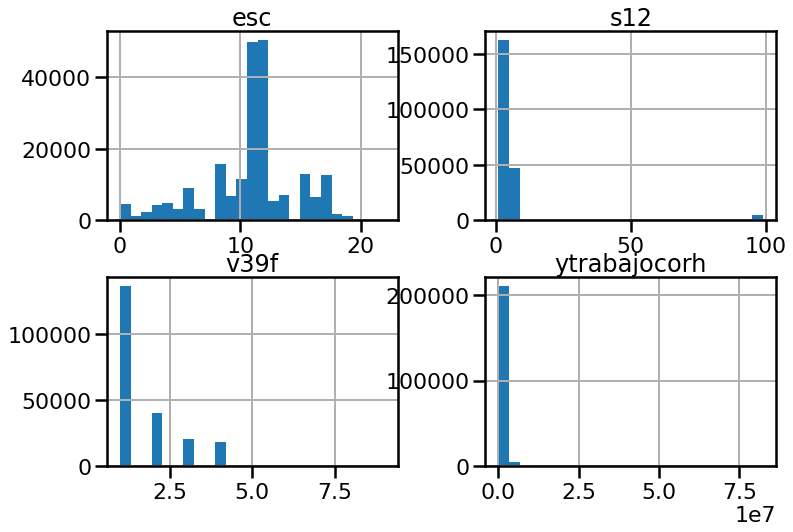

In [14]:
columns = ['folio', 
           'o', 
           'sexo',
           'asiste',
           'edad',
           'pareja', 
           'ecivil',
           'id_vivienda', 
           'hogar', 
           'varstrat', 
           'varunit', 
           'expr_div', 
           'expr', 
           'expc',
           'fecha_dia',
           'fecha_mes',
           'fecha_año',
           'provincia',
           'comuna']

casen_rel = prepare_casen_data(casen, columns, 0.2)

casen_rel

## Preparation and visualization of the mobility data

In [48]:
def prepare_mobility_data(df, country, start, end, include_regions=True, drop_date=True):
    """
    Function to prepare the Google mobility data for any specific country to merge it with the Covid data
    or to plot it. 
    
    Input: 
        df (DataFrame): DataFrame with mobility data
        country (string): Name of the country
        start (string): First day of mobility data
        end (string): Last day of mobility data
        include_regions (bool): Decide if regions should be included. Many countries do not have
        information about the regions, in this case the function would return an empty DataFrame
        drop_date (bool): Decide if 'date' column should be dropped
        
    Output: 
        df_country (DataFrame)
    """

    # Get mobility data for a specific country and leave the rows that are not connected to a region.
    if include_regions == True:
        country_mobility = df[(df['country_region'] == country) & (~df['sub_region_1'].isna())]
    else:
        country_mobility = df[(df['country_region'] == country)]
        
    # Drop columns that are not needed further. 
    country_mobility = country_mobility.drop([
                                'country_region',
                                'country_region_code', 
                                'sub_region_2', 
                                'metro_area', 
                                'iso_3166_2_code', 
                                'census_fips_code'
                            ], axis = 1)
    
    # Rename columns
    country_mobility.columns = ['sub_region_1', 
                                'date',
                                'retail_and_recreation',
                                'grocery_and_pharmacy',
                                'parks',
                                'transit_stations',
                                'workplaces',
                                'residential']
 
    # Convert mobility columns to float.
    info_columns = ['retail_and_recreation',
                   'grocery_and_pharmacy',
                   'parks',
                   'transit_stations',
                   'workplaces',
                   'residential']
    country_mobility[info_columns] = country_mobility[info_columns].astype(float)
  
    # Group mobility data by region and get mean value for each region and date.
    if include_regions == True:
        country_mobility = country_mobility.groupby(['sub_region_1', 'date'])[info_columns].mean().reset_index()
    else: 
        country_mobility = country_mobility.groupby(['date'])[info_columns].mean().reset_index()
    
    # Convert 'date' column to datetime.
    country_mobility.loc[:, 'date'] = pd.to_datetime(country_mobility.loc[:, 'date'])
    
    # Get data for a specific date
    country_mobility = country_mobility[(country_mobility['date'] >= start) & (country_mobility['date'] <= end)]

    
    # Add column 'days' that counts the days from the start. Given that the DataFrame includes 16 regions,
    # the 'days' column should count up to 156 for every region. 
    country_mobility['days'] = 0   
    country_mobility = country_mobility.assign(days = np.arange(len(country_mobility)) % 157)
      
    # Drop the 'date' column
    if drop_date == True: 
        country_mobility = country_mobility.drop(['date'], axis = 1)
    else: 
        pass

    return country_mobility

mobility_chile = prepare_mobility_data(mobility, 'Chile', '2020-03-04', '2020-08-07', include_regions=True, drop_date=False)

mobility_chile.head()

,sub_region_1,date,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,days
18,Antofagasta,2020-03-04,0.25,8.666667,-11.25,8.25,17.500000,-0.666667,0
19,Antofagasta,2020-03-05,0.50,6.666667,-13.25,4.75,19.250000,-1.000000,1
20,Antofagasta,2020-03-06,4.25,7.666667,-9.25,4.50,19.500000,-1.000000,2
21,Antofagasta,2020-03-07,8.75,8.333333,-9.00,-3.00,5.500000,2.333333,3
22,Antofagasta,2020-03-08,14.50,23.000000,-1.50,2.50,1.666667,3.333333,4


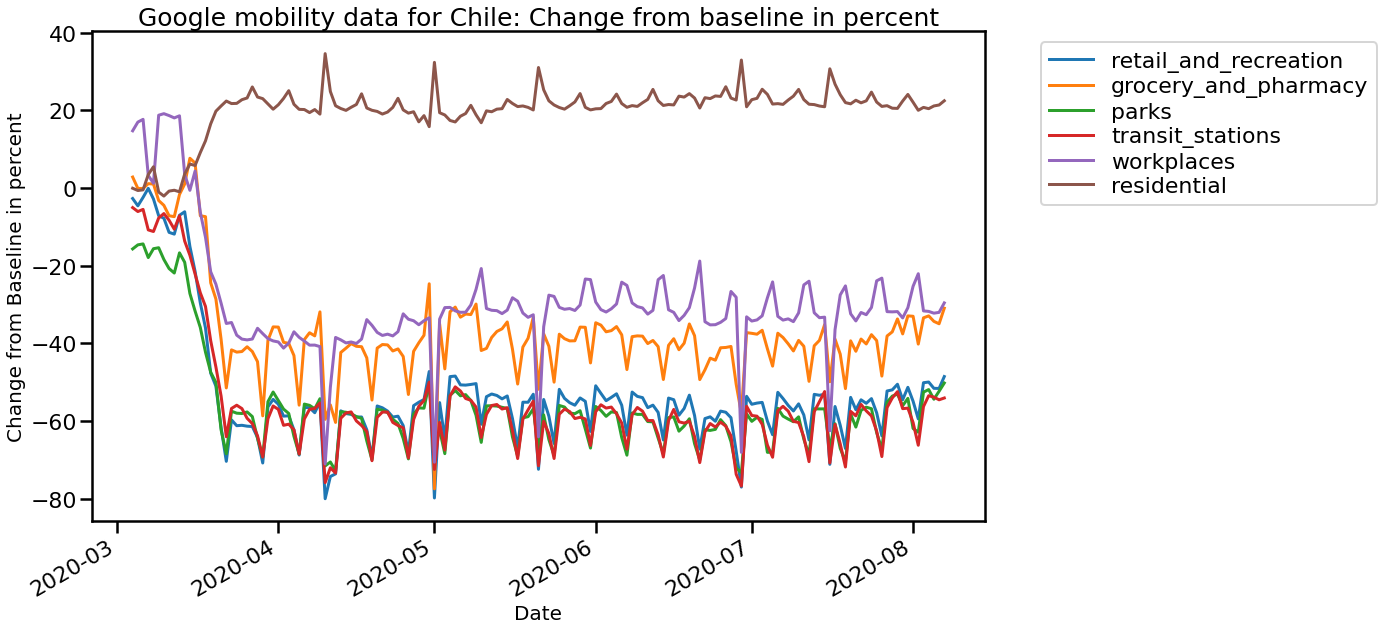

In [38]:
def make_mobility_plot(df, country, start, end, include_regions=False, drop_date=True):
    """
    Function to plot the mobility data for a specific country and for specific start and end dates. 
    
    Input: 
        df (DataFrame): DataFrame with mobility data
        country (string): Name of the country
        start (string): First day of mobility data
        end (string): Last day of mobility data
        include_regions (bool): Decide if regions should be included. Many countries do not have
        information about the regions, in this case the function would return an empty DataFrame
        drop_date (bool): Decide if 'date' column should be dropped
        
    Output: 
        A seaborn lineplot

    """
    
    # Get mobility data for a specific country
    mobility_df = prepare_mobility_data(df, country, start, end, include_regions=False, drop_date=False)

    # Rename column names for better readability
    column_names = ['retail_and_recreation',
                   'grocery_and_pharmacy',
                   'parks',
                   'transit_stations',
                   'workplaces',
                   'residential']
    
    # Create figure
    fig, ax = plt.subplots(figsize = (16,10))
    
    # Make a lineplot for each category
    for item in column_names: 
        sns.lineplot(x = mobility_df['date'], y = mobility_df[item])

    # Place legend outside plot
    plt.legend(column_names, scatterpoints=1, frameon=True, labelspacing=.2, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5)

    # Define plot title and labels, automatically rotate labels if necessary
    plt.title('Google mobility data for {}: Change from baseline in percent'.format(country), fontsize = 25)
    plt.ylabel('Change from Baseline in percent', fontsize = 20)
    plt.xlabel('Date', fontsize = 20)
    fig.autofmt_xdate()
    
    plt.show()
    
make_mobility_plot(mobility, 'Chile', '2020-03-04', '2020-08-07', include_regions=False, drop_date=False)

In [49]:
# Given that some region names in the mobility data are different from the other datasets, 
# they are changed: 

mobility_chile['sub_region_1'] = mobility_chile['sub_region_1'].map({
                                                'Tarapacá': 'Tarapacá',
                                                'Antofagasta': 'Antofagasta',
                                                'Atacama': 'Atacama',
                                                'Coquimbo': 'Coquimbo',
                                                'Valparaíso': 'Valparaíso',
                                                "O'Higgins": 'O’Higgins',
                                                'Maule': 'Maule',
                                                'Bio Bio': 'Biobío',
                                                'Araucania': 'Araucanía', 
                                                'Los Lagos': 'Los Lagos',
                                                'Aysén': 'Aysén',
                                                'Magallanes and Chilean Antarctica': 'Magallanes',
                                                'Santiago Metropolitan Region': 'Metropolitana',
                                                'Los Ríos': 'Los Ríos',
                                                'Arica y Parinacota': 'Arica y Parinacota',
                                                'Ñuble': 'Ñuble'
                                            })

mobility_chile.head()

,sub_region_1,date,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,days
18,Antofagasta,2020-03-04,0.25,8.666667,-11.25,8.25,17.500000,-0.666667,0
19,Antofagasta,2020-03-05,0.50,6.666667,-13.25,4.75,19.250000,-1.000000,1
20,Antofagasta,2020-03-06,4.25,7.666667,-9.25,4.50,19.500000,-1.000000,2
21,Antofagasta,2020-03-07,8.75,8.333333,-9.00,-3.00,5.500000,2.333333,3
22,Antofagasta,2020-03-08,14.50,23.000000,-1.50,2.50,1.666667,3.333333,4


# Feature analysis

## Analyze correlation of features with Covid-19 cases/deaths

In [ ]:
def get_transposted_df(df, title):
    
    """
    To analyze the correlation between Covid-19 cases/deaths and the CASEN data, 
    it is necessary to transpose the Covid-19 cases/deaths DataFrame. 
    
    Input: 
        df (DataFrame): DataFrame that should be transposed. 
        title (string): Specific if DataFrame is with data about cases or deaths
        
    Output: 
        transposed_df (DataFrame): Transposed version of the DataFrame. 
    """
    
    # Prepare df by transposing it (name of regions as rows)
    transposed_df = (np.transpose(df))
    
    # Change column names to dates
    transposed_df.columns = transposed_df.iloc[0, :]

    # Drop first row (no information)
    transposed_df = transposed_df.drop('Region', axis = 0).reset_index()
    transposed_df = transposed_df.rename(columns = {'index': 'region'})
    
    return transposed_df

transposed_cases = get_transposted_df(cases_regions, 'cases')
transposed_deaths = get_transposted_df(deaths_regions, 'deaths')

In [ ]:
def merge_casen_data(transposed_df, casen_data, title):
    """
    Function to merge the CASEN data with a transposed DataFrame. 
    
    Input: 
        transposed_df (DataFrame): Transposed DataFrame with information about Covid-19 cases/deaths.
        casen_data (DataFrame): The CASEN data that should be merged with the transposed DataFrame. 
        title (string): Specific if DataFrame is with data about cases or deaths.
        
    Output: 
        casen_merged (DataFrame): A DataFrame with the mean of indicator for each region and 
        information about the most recent amount of Covid-19 cases/deaths.
    
    """
    
    # Given that the DataFrame is updated every day, the name of the last column (the 
    # current amount of Covid-19 cases/deaths) changes every day. 
    last_column = transposed_df.columns[-1]
    
    # Store only the name of the region and the last column as new DataFrame
    df_result = transposed_df.loc[:, ['region', last_column]]
    df_result = df_result.rename(columns = {last_column: title})

    # Group CASEN data by regions by taking the mean of every indicator
    casen_regions = casen_data.groupby('region')[[i for i in casen_data.columns[1:]]].mean().reset_index()

    # Merge CASEN data and information about amount of Covid-19 cases/deaths
    casen_merged = casen_regions.merge(df_result, on = 'region')
    
    # Change type of column title to float
    casen_merged[title] = casen_merged[title].astype('float')
    
    return casen_merged

casen_merged_cases = merge_casen_data(transposed_cases, casen_rel, 'cases')
casen_merged_deaths = merge_casen_data(transposed_deaths, casen_rel, 'deaths')

In [ ]:
def get_corr(casen_merged, title):
    """
    Function to get the correlation between the CASEN socio-economic indicators and the number 
    of Covid-19 cases/deaths in Chile. 
    
    Input: 
        casen_merged (DataFrame): A DataFrame with the mean of indicator for each region and 
        information about the most recent amount of Covid-19 cases/deaths.
        title: Specify the kind of the plot (cases or deaths).
        
    Output: 
        corr (series): Series with pairwise correlation of CASEN indicators with amount of 
        Covid-19 cases/deaths in Chile. 
    """
    
    # Drop 'region' column from casen_merged, as it is not needed here. 
    casen_merged = casen_merged.drop('region', axis = 1)

    # Get correlation with title and sort values from highest correlation to lowest
    corr = casen_merged.corrwith(casen_merged[title]).sort_values(ascending = False)
    
    return corr

In [ ]:
get_corr(casen_merged_cases, 'cases')

In [ ]:
get_corr(casen_merged_deaths, 'deaths')

In [ ]:
def plot_indicator_vs_amount(transposed_df, casen_data, title, high, low):
    """
    Function to prepare a scatterplot of the amount of Covid-19 cases/deaths vs. the CASEN indicators
    with highest and lowest correlation. 
    
    Input: 
        transposed_df (DataFrame): Transposed DataFrame with information about Covid-19 cases/deaths.
        casen_data (DataFrame): The CASEN data that should be merged with the transposed DataFrame.
        title: Specify the kind of the plot (cases or deaths).
    
    Output: 
        Seaborn plots of cases vs. specific indicator. 
    """
    

    highest = list(get_corr(merge_casen_data(transposed_df, casen_data, title), title).index[1:high])
    lowest = list(get_corr(merge_casen_data(transposed_df, casen_data, title), title).index[low*-1:])

    casen_sel = casen_data[['region'] + highest + lowest]

    df_plot = merge_casen_data(transposed_df, casen_sel, title)

    #fig = plt.figure()

    for item in (highest + lowest):

        fig = plt.figure(figsize = (13, 10))

        ax = sns.scatterplot(x = df_plot[item], y = df_plot[title], sizes = (300, 1000), size = df_plot[title], hue = df_plot['region'])
        plt.title('Scatterplot for {} vs. indicator: {}'.format(title, item), fontsize = 25)
        plt.ylabel(title, fontsize = 20)
        plt.xlabel('Indicator: {}'.format(item), fontsize = 20)
        ax.yaxis.grid()
        sns.despine()
        plt.legend(scatterpoints=1, frameon=True, labelspacing=0.2, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

        plt.show()

In [ ]:
plot_indicator_vs_amount(transposed_cases, casen_rel, 'cases', 6, 6)

In [ ]:
plot_indicator_vs_amount(transposed_deaths, casen_rel, 'deaths', 6, 6)

In [ ]:


mobility['sub_region_1'] = mobility['sub_region_1'].map({
    'Tarapacá': 'Tarapacá',
    'Antofagasta': 'Antofagasta',
    'Atacama': 'Atacama',
    'Coquimbo': 'Coquimbo',
    'Valparaíso': 'Valparaíso',
    "O'Higgins": 'O’Higgins',
    'Maule': 'Maule',
    'Bio Bio': 'Biobío',
    'Araucania': 'Araucanía', 
    'Los Lagos': 'Los Lagos',
    'Aysén': 'Aysén',
    'Magallanes and Chilean Antarctica': 'Magallanes',
    'Santiago Metropolitan Region': 'Metropolitana',
    'Los Ríos': 'Los Ríos',
    'Arica y Parinacota': 'Arica y Parinacota',
    'Ñuble': 'Ñuble'
})

mobility_chile = mobility[(mobility['country_region'] == 'Chile') & (~mobility['sub_region_1'].isna())]

mobility_chile = mobility_chile.drop([
    'country_region',
    'country_region_code', 
    'sub_region_2', 
    'metro_area', 
    'iso_3166_2_code', 
    'census_fips_code'
], axis = 1)

mobility_chile.loc[:, 'date'] = pd.to_datetime(mobility_chile.loc[:, 'date'])

# Convert mobility columns to float
info_columns = ['retail_and_recreation_percent_change_from_baseline', 
                'grocery_and_pharmacy_percent_change_from_baseline',
               'parks_percent_change_from_baseline',
               'transit_stations_percent_change_from_baseline',
               'workplaces_percent_change_from_baseline',
               'residential_percent_change_from_baseline']

mobility_chile[info_columns] = mobility_chile[info_columns].astype(float)

mobility_chile = mobility_chile.groupby(['sub_region_1', 'date'])[info_columns].mean().reset_index()

mobility_chile = mobility_chile[(mobility_chile['date'] >= '2020-03-04') & (mobility_chile['date'] <= '2020-08-07')]

mobility_chile['days'] = 0

mobility_chile = mobility_chile.assign(days = np.arange(len(mobility_chile)) % 157)

mobility_chile = mobility_chile.drop(['date'], axis = 1)

mobility_chile

In [ ]:
# Define rsmle

def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

In [ ]:
df = cases_regions.copy()
title = 'cases'



df = df[(df['Region'] >= '2020-03-04') & (df['Region'] <= '2020-08-07')]

df.insert(0, 'days', range(len(df)))

df = df.drop(['Region'], axis = 1)


df_melt = pd.melt(
    df, id_vars = ['days'], 
    value_vars = df.columns.drop(['days']), 
    value_name=title
)

df_melt = df_melt.loc[df_melt['variable'] != 'Total', :]

df_melt['yesterday_value'] = df_melt.groupby('variable')[title].shift()

df_melt['yesterday_diff'] = df_melt.groupby('variable')['yesterday_value'].diff()

df_mobility = df_melt.merge(mobility_chile, left_on = ['days', 'variable'], right_on = ['days', 'sub_region_1'], how = 'left')

df_mobility = df_mobility.drop(['sub_region_1'], axis = 1)

df_mobility = df_mobility.fillna(method = 'bfill', axis = 0)

df_mobility

In [ ]:
y = df_mobility['cases']
X = df_mobility.drop(['cases'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
mean_error = []
for day in range(3, 157):
    train = df_mobility[df_mobility['days'] < day]
    val = df_mobility[df_mobility['days'] == day]

    p = val['yesterday_value'].values

    error = rmsle(val['cases'].values, p)
    print('day %d - Error %.5f' % (day, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

In [ ]:
# To make sure the model is worth using I like to set a baseline score that it has to beat. In this case, a reasonably strong baseline is using the last week amount of sales as a prediction for the sales this week.
# What is my baseline score? 

In [ ]:
mean_error = []
for day in range(6, 26):

    mdl = RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=0)
    mdl.fit(X_train, y_train)

    y_pred = mdl.predict(X_test)

    error = rmsle(y_test, y_pred)
    print('day %d - Error %.5f' % (day, error))
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

